<a href="https://colab.research.google.com/github/uvais-6/Generative-AI/blob/main/Exp_3_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
class Generator (nn.Module):
  def __init__(self, z_dim):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(z_dim, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, 512)
    self.fc4 = nn.Linear(512, 1024)
    self.fc5 = nn.Linear(1024, 28*28)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc4(x))
    x = self.tanh(self.fc5(x))
    return x.view(x.size(0), 1 , 28, 28)

class Critic(nn.Module):
  def __init__(self):
    super(Critic, self).__init__()
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 1)
    self.leaky_relu = nn.LeakyReLU(0.2)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.leaky_relu(self.fc1(x))
    x = self.leaky_relu(self.fc2(x))
    x = self.leaky_relu(self.fc3(x))
    return self.fc4(x)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.20MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def wasserstein_loss(y_true, y_pred):
  return torch.mean(y_true * y_pred)

def compute_gradient_penalty(critic, real_images, fake_images, device):
  batch_size, C, H, W = real_images.size()
  epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
  interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
  interpolated_images.requires_grad_(True)

  critic_interpolated_output = critic(interpolated_images)

  # Assign critic_interpolated_output to critic_outputs
  critic_outputs = critic_interpolated_output

  gradient = torch.autograd.grad(
      outputs=critic_interpolated_output,
      inputs=interpolated_images,
      # Use critic_outputs instead of critic_interpolated_output here
      grad_outputs=torch.ones_like(critic_outputs),
      create_graph = True, retain_graph=True,
  )[0]


  gradient = gradient.view(batch_size, -1)
  gradient_norm = gradient.norm(2, dim=1)
  penalty = ((gradient_norm-1)**2).mean()

  return penalty

In [ ]:
z_dim = 100
lr = 0.00005
n_critic = 5
lamba_gp = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(z_dim).to(device)
critic = Critic().to(device)

optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/3], Critic Loss: -9.740151405334473, Generator Loss: -0.7608078718185425


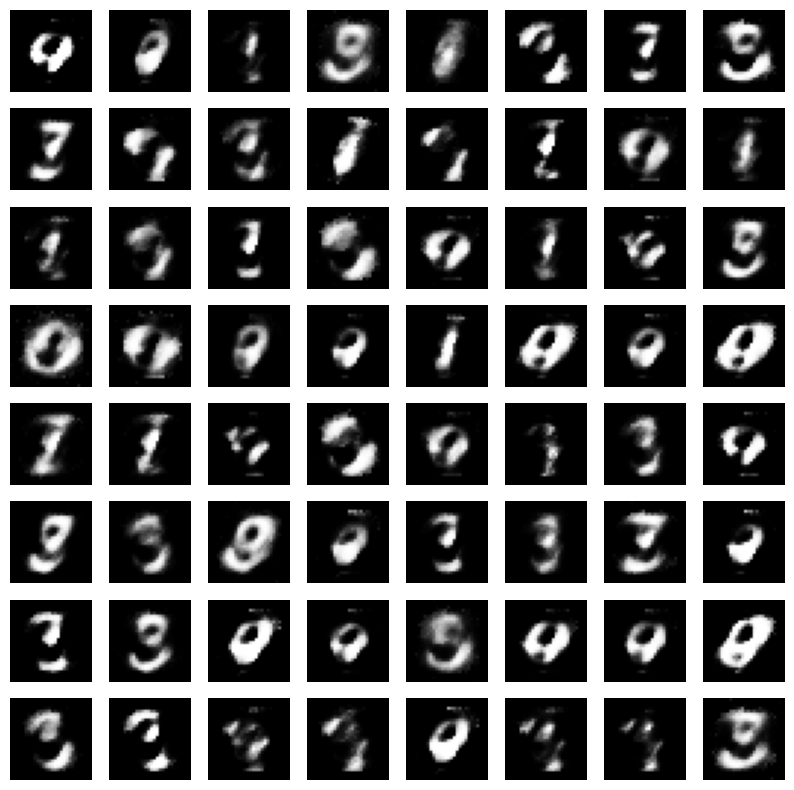

Epoch [1/3], Critic Loss: -8.700778007507324, Generator Loss: 6.146571159362793
Epoch [2/3], Critic Loss: -9.414701461791992, Generator Loss: 7.228104591369629


In [ ]:
epochs = 3
for epoch in range (epochs):
  for i, (real_images, _) in enumerate(train_loader):
    real_images = real_images.to(device)
    batch_size = real_images.size(0)

    for _ in range(n_critic):
      z = torch.randn(batch_size, z_dim).to(device)
      fake_images = generator(z)
      critic_real= critic(real_images)
      critic_fake= critic(fake_images)

      gradient_penalty = compute_gradient_penalty(critic, real_images, fake_images, device)

      critic_loss = -torch.mean(critic_real) + torch.mean(critic_fake) + lamba_gp * gradient_penalty

      optim_critic.zero_grad()
      critic_loss.backward()
      optim_critic.step()

    z = torch.randn(batch_size, z_dim).to(device)
    fake_images = generator(z)
    critic_fake = critic(fake_images)

    gen_loss = -torch.mean(critic_fake)

    optim_gen.zero_grad()
    gen_loss.backward()
    optim_gen.step()

  print(f"Epoch [{epoch}/{epochs}], Critic Loss: {critic_loss.item()}, Generator Loss: {gen_loss.item()}")

  if epoch % 10 == 0:
    with torch.no_grad():
      test_z = torch.randn(64, z_dim).to(device)
      generated_images = generator(test_z)
      generated_images = generated_images.cpu().data
      generated_images = generated_images.view(64, 28, 28)

      plt.figure(figsize=(10, 10))
      for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
      plt.show()